# Swiss commerce register

The Federal Office of Justice maintains ZEFIX, the swiss commerce register for all legally operating businesses.


The register provides us with company name, type, description, and address.   
ZEFIX is also available as [Linked Data](https://en.wikipedia.org/wiki/Linked_data). 


### SPARQL endpoints

#### For companies data
Swiss commerce register data can be accessed with [SPARQL queries](https://www.w3.org/TR/rdf-sparql-query/).   
You can send queries using HTTP requests. The API endpoint is **[https://lindas.admin.ch/query/](https://int.lindas.admin.ch/query).**  

#### For geodata
To understand companies' location, we will work with Swiss geodata. It can be accessed with GeoSPARQL under **[https://ld.geo.admin.ch/query](https://ld.geo.admin.ch/query).**  

### SPARQL client

Let's use `SparqlClient` from [graphly](https://github.com/zazuko/graphly) to communicate with both databases. 
Graphly will allow us to:
* send SPARQL queries
* automatically add prefixes to all queries
* format response to `pandas` or `geopandas`

In [1]:
import textwrap

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from graphly.api_client import SparqlClient
from plotly.subplots import make_subplots

%matplotlib inline

In [2]:
sparql = SparqlClient("https://lindas.admin.ch/query")
geosparql = SparqlClient("https://ld.geo.admin.ch/query")

sparql.add_prefixes(
    {"schema": "<http://schema.org/>", "admin": "<https://schema.ld.admin.ch/>"}
)

geosparql.add_prefixes(
    {
        "dct": "<http://purl.org/dc/terms/>",
        "geonames": "<http://www.geonames.org/ontology#>",
        "schema": "<http://schema.org/>",
        "geosparql": "<http://www.opengis.net/ont/geosparql#>",
    }
)

In [3]:
## Per canton

query = """SELECT ?canton ?canton_id (COUNT(?sub) AS ?tot_companies)
FROM <https://lindas.admin.ch/foj/zefix>
FROM <https://lindas.admin.ch/territorial>
WHERE {
	?sub a admin:ZefixOrganisation ;
      admin:municipality ?muni_id.
  	?muni_id schema:containedInPlace ?canton_id .
    ?canton_id a admin:Canton .
  	?canton_id schema:name ?canton .
  
  	FILTER (lang(?canton) = 'en')
} 
GROUP BY ?canton ?canton_id
"""
kanton_companies = sparql.send_query(query)
kanton_companies.sort_values("tot_companies", ascending=False).head()

,canton,canton_id,tot_companies
2,Zurich,https://ld.admin.ch/canton/1,125150
17,Bern,https://ld.admin.ch/canton/2,65219
22,Vaud,https://ld.admin.ch/canton/22,62661
18,Geneva,https://ld.admin.ch/canton/25,52678
7,Aargau,https://ld.admin.ch/canton/19,42770


## Companies containing a name per canton

In [4]:
def query_filter_company_name(name):
    """Return a SPARQL query to search for companies which contain 'name'."""
    return textwrap.dedent(
        f"""
            SELECT ?canton_id (COUNT(?sub) AS ?{name}_companies)
            FROM <https://lindas.admin.ch/foj/zefix>
            FROM <https://lindas.admin.ch/territorial>
            WHERE {{
                ?sub a admin:ZefixOrganisation ;
                  admin:municipality ?muni_id;
                  schema:legalName ?name . 
                ?muni_id schema:containedInPlace ?canton_id .
                ?canton_id a admin:Canton .
  
                FILTER regex(?name, "{name}", "i")
            }} 
            GROUP BY ?canton_id
            ORDER BY DESC(?{name}_companies)"""
    )

In [5]:
# Kantons
query = """    
SELECT ?boundary ?canton_id

WHERE {
  ?canton_iri dct:hasVersion ?version ;
            geonames:featureCode geonames:A.ADM1 .
  
  ?version schema:validUntil "2020-12-31"^^<http://www.w3.org/2001/XMLSchema#date>;
           geosparql:hasGeometry/geosparql:asWKT ?boundary.
  
  BIND(IRI(REPLACE(STR(?canton_iri), "https://geo.ld.admin.ch/boundaries/", "https://ld.admin.ch/")) AS ?canton_id)
}
"""
geo_cantons = geosparql.send_query(query)
geo_cantons = geo_cantons.set_crs(epsg=4326)
geo_cantons.head()

,boundary,canton_id
0,"POLYGON ((7.02724 47.50133, 7.03698 47.49750, ...",https://ld.admin.ch/canton/26
1,"MULTIPOLYGON (((6.17051 46.29428, 6.19870 46.2...",https://ld.admin.ch/canton/25
2,"POLYGON ((8.25860 47.28720, 8.26163 47.28254, ...",https://ld.admin.ch/canton/3
3,"POLYGON ((8.66961 47.67475, 8.67687 47.67182, ...",https://ld.admin.ch/canton/1
4,"MULTIPOLYGON (((9.47629 47.48934, 9.46418 47.4...",https://ld.admin.ch/canton/20


In [6]:
combined_companies = (
    kanton_companies.merge(
        sparql.send_query(query_filter_company_name("suisse")), how="outer"
    )
    .merge(sparql.send_query(query_filter_company_name("swiss")), how="outer")
    .merge(sparql.send_query(query_filter_company_name("svizzera")), how="outer")
    .merge(sparql.send_query(query_filter_company_name("schweiz")), how="outer")
    .merge(sparql.send_query(query_filter_company_name("helvetia")), how="outer")
    .merge(geo_cantons, how="outer")
    .fillna(value=0)
)
combined_companies.head()

,canton,canton_id,tot_companies,suisse_companies,swiss_companies,svizzera_companies,schweiz_companies,helvetia_companies,boundary
0,Jura,https://ld.admin.ch/canton/26,6080,54,88,0.0,6,2.0,"POLYGON ((7.02724 47.50133, 7.03698 47.49750, ..."
1,Appenzell Innerrhoden,https://ld.admin.ch/canton/16,2010,7,46,0.0,42,0.0,"MULTIPOLYGON (((9.37930 47.38574, 9.37832 47.3..."
2,Zurich,https://ld.admin.ch/canton/1,125150,387,2442,5.0,2332,38.0,"POLYGON ((8.66961 47.67475, 8.67687 47.67182, ..."
3,Basel Landschaft,https://ld.admin.ch/canton/13,19215,42,238,0.0,326,6.0,"MULTIPOLYGON (((7.37568 47.41408, 7.36314 47.4..."
4,Neuchâtel,https://ld.admin.ch/canton/24,12316,130,186,0.0,14,3.0,"POLYGON ((6.87081 47.10211, 6.86689 47.08512, ..."


In [7]:
relative_companies = (
    combined_companies.filter(regex="\w{4,}_\w{3,}")
    .apply(lambda x: round(10000 * x / combined_companies.tot_companies))
    .rename(columns=lambda x: x.replace("companies", "per_10k"))
)

companies = combined_companies.join(relative_companies).astype(int, errors="ignore")
companies.head()

,canton,canton_id,tot_companies,suisse_companies,swiss_companies,svizzera_companies,schweiz_companies,helvetia_companies,boundary,suisse_per_10k,swiss_per_10k,svizzera_per_10k,schweiz_per_10k,helvetia_per_10k
0,Jura,https://ld.admin.ch/canton/26,6080,54,88,0,6,2,"POLYGON ((7.02724 47.50133, 7.03698 47.49750, ...",89,145,0,10,3
1,Appenzell Innerrhoden,https://ld.admin.ch/canton/16,2010,7,46,0,42,0,"MULTIPOLYGON (((9.37930 47.38574, 9.37832 47.3...",35,229,0,209,0
2,Zurich,https://ld.admin.ch/canton/1,125150,387,2442,5,2332,38,"POLYGON ((8.66961 47.67475, 8.67687 47.67182, ...",31,195,0,186,3
3,Basel Landschaft,https://ld.admin.ch/canton/13,19215,42,238,0,326,6,"MULTIPOLYGON (((7.37568 47.41408, 7.36314 47.4...",22,124,0,170,3
4,Neuchâtel,https://ld.admin.ch/canton/24,12316,130,186,0,14,3,"POLYGON ((6.87081 47.10211, 6.86689 47.08512, ...",106,151,0,11,2


In [8]:
print("For every 10,000 companies:")
for ch in "swiss schweiz suisse helvetia svizzera".split():
    lang = companies[ch + "_companies"].sum()
    print(
        f"\t{round(lang/companies.tot_companies.sum()*10000)} contain '{ch.capitalize()}' ({lang} in total)"
    )

For every 10,000 companies:
	183 contain 'Swiss' (13178 in total)
	107 contain 'Schweiz' (7685 in total)
	61 contain 'Suisse' (4382 in total)
	3 contain 'Helvetia' (248 in total)
	3 contain 'Svizzera' (190 in total)


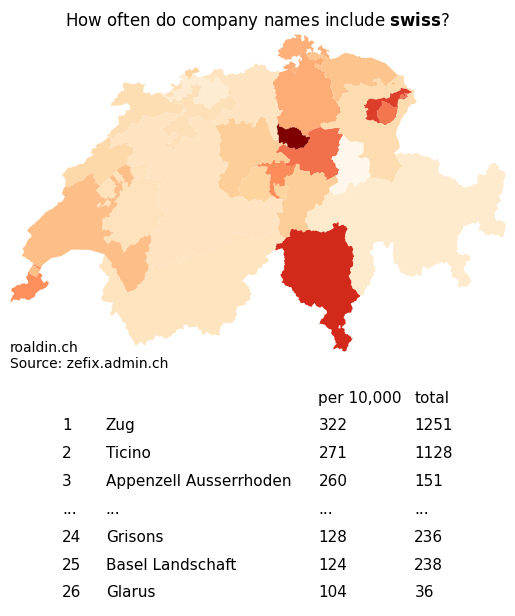

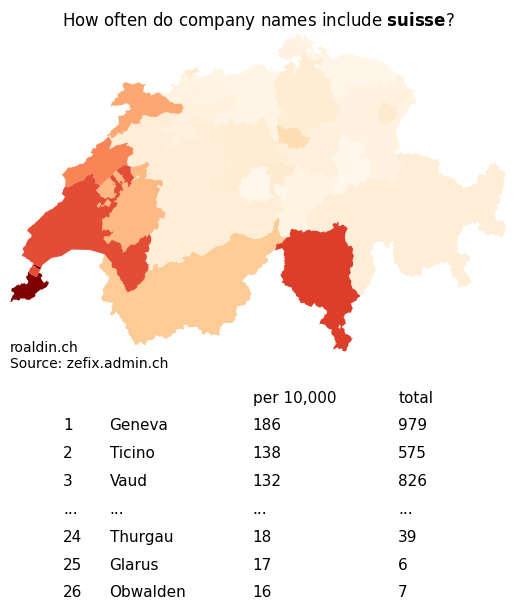

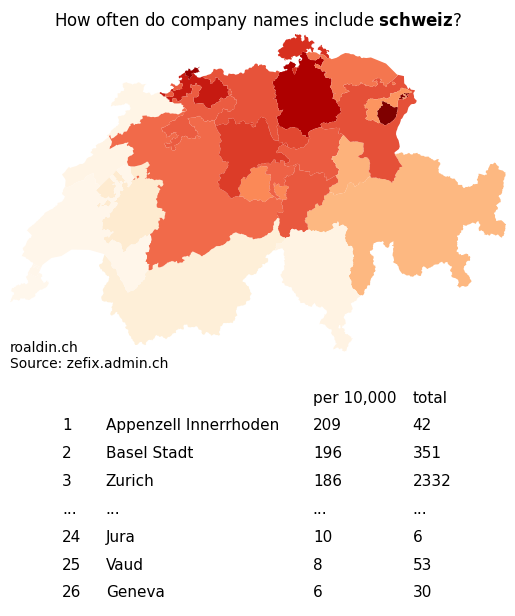

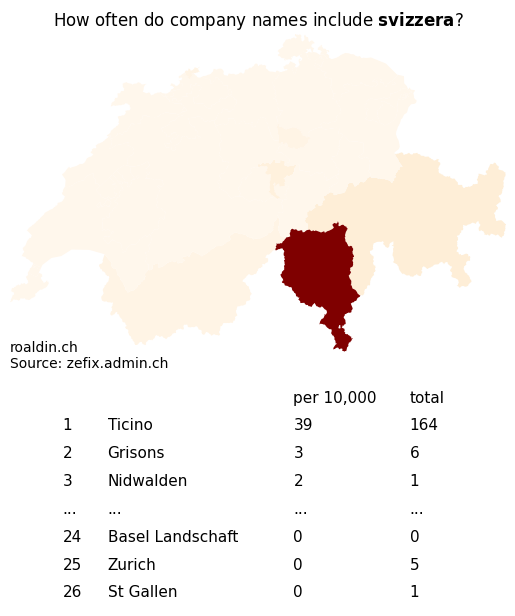

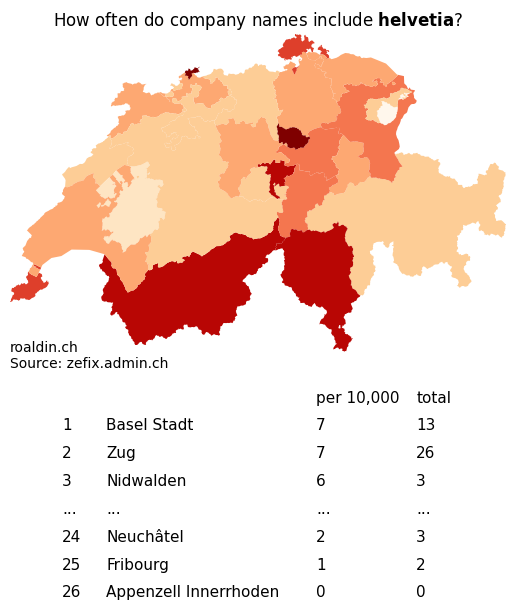

In [11]:
pd.DataFrame.less = lambda df, n=10: pd.concat(
    [
        df.head(n // 2),
        pd.DataFrame(data=[["..."] * len(df.columns)], columns=df.columns),
        df.tail(n // 2),
    ]
)

## English
p = gpd.GeoDataFrame(companies).set_geometry("boundary")
for ch in "swiss suisse schweiz svizzera helvetia".split():
    p.plot(column=f"{ch}_per_10k", cmap="OrRd", legend=False)
    plt.title(r"How often do company names include $\bf{" + ch + "}$?")
    plt.text(
        0, -0.05, s="roaldin.ch\nSource: zefix.admin.ch", transform=plt.gca().transAxes
    )

    cols_to_show = f"canton {ch}_per_10k {ch}_companies".split()
    sorted_companies = companies[cols_to_show].sort_values(
        f"{ch}_per_10k", ascending=False
    )
    sorted_companies["position"] = range(1, len(sorted_companies) + 1)

    formatted_col_labels = ["", "", "per 10,000", "total"]
    table = plt.table(
        cellText=sorted_companies[["position"] + cols_to_show].less(n=6).values,
        colLabels=formatted_col_labels,
        edges="open",
        # loc='bottom',
        bbox=[0.1, -0.8, 0.8, 0.7],
    )

    table.auto_set_column_width(col=list(range(len(sorted_companies.columns))))
    table.scale(1, 1.7)
    table.set_fontsize(11)

    for key, cell in table.get_celld().items():
        cell.set_text_props(ha="left")

    plt.gca().set_axis_off()
    plt.margins(0, 0)
    plt.savefig(f"{ch}.png", dpi=150, bbox_extra_artists=(table,), bbox_inches="tight")
    plt.show()
    plt.close()